This project applies sentiment analysis to a financial text dataset using Recurrent Neural Networks (RNNs). Two model architectures are implemented: Long Short-Term Memory (LSTM) networks and Bidirectional LSTM networks. The objective is to capture subtle linguistic patterns in financial language and classify text into sentiment categories more accurately.

In [ ]:
import pandas as pd
import re
import nltk
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/NLP Dataset/data.csv")


lemmatizer = WordNetLemmatizer()

def preprocess_data(text):
    text = text.lower()

    text = text.lower()

    # remove urls and mentions
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)

    # remove '#' but keep the word
    text = text.replace('#', '')

    # allow only letters, numbers, space, $, ., !, ?, '
    text = re.sub(r"[^a-z0-9\s\$\.\!?\']", ' ', text)

    # normalize punctuation cues
    text = re.sub(r'!+', ' exclamation ', text)
    text = re.sub(r'\?+', ' question ', text)

    # normalize elongated words (soooo -> soo)
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)

    # remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # lemmatize
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if len(w) > 1]

    return ' '.join(words)


# Apply preprocessing
df['Sentence'] = df['Sentence'].apply(preprocess_data)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                            Sentence Sentiment
0  the geosolutions technology will leverage bene...  positive
1  $esi on low down $1.50 to $2.50 bk real possib...  negative
2  for the last quarter of 2010 componenta 's net...  positive
3  according to the finnish russian chamber of co...   neutral
4  the swedish buyout firm ha sold it remaining 2...   neutral


In [ ]:
# Tokenization, Sequence pading, Spliting dataset
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


# Parameters
MAX_NUM_WORDS = 10000
MAX_SEQ_LEN = 100

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df['Sentence'])

# Convert texts → sequences of integers
sequences = tokenizer.texts_to_sequences(df['Sentence'])

# Pad/truncate sequences to same length
X = pad_sequences(sequences, maxlen=MAX_SEQ_LEN, padding='post', truncating='post')

# Encode labels
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
Y = encoder.fit_transform(df['Sentiment'])
label_names = encoder.classes_.tolist()


# Split dataset into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)






In [ ]:
# Create RNN with LSTM layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
VOCAB_SIZE = min(MAX_NUM_WORDS, len(tokenizer.word_index) + 2)

def build_model():
    model = Sequential()
    model.add(Embedding(input_dim=VOCAB_SIZE,
                        output_dim=100,
                        input_length=MAX_SEQ_LEN,
                        mask_zero=True))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(3, activation='softmax'))     # 3 classes
    model.compile(
        loss='sparse_categorical_crossentropy',   # y are ints 0/1/2
        optimizer='adam',
        metrics=['accuracy']
    )
    return model


In [ ]:
# Create RNN with LSTM and Bidirectional layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
VOCAB_SIZE = min(MAX_NUM_WORDS, len(tokenizer.word_index) + 2)

def build_model_bi():
    model = Sequential()
    model.add(Embedding(input_dim=VOCAB_SIZE,
                        output_dim=100,
                        input_length=MAX_SEQ_LEN,
                        mask_zero=True))
    model.add(Bidirectional(LSTM(64, return_sequences=False)))
    model.add(Dropout(0.3))
    model.add(Dense(3, activation='softmax'))     # 3 classes
    model.compile(
        loss='sparse_categorical_crossentropy',   # y are ints 0/1/2
        optimizer='adam',
        metrics=['accuracy']
    )
    return model

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import plot_model

# Keras API training using fit() handles batching, epoch, validation, early stopping.
# LSTM and Bididrectional
# Initialize models
lstm = build_model()
bi_lstm = build_model_bi()
def run_model(model):
  """ Build and compile a model."""
  model.build(input_shape=(None, MAX_SEQ_LEN))
  model.summary()
  return model

def train(model, X_train, y_train, X_test, y_test):
  """Train a model on the provided training data."""
  training = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
  return training

def predict_sentiment(model, X_test, y_test):
  """Make predictions on the provided test data."""
  y_probs = model.predict(X_test)
  y_preds = np.argmax(y_probs, axis=1)
  return y_preds, y_probs



#  Build and Train the models
lstm_model = run_model(lstm)
lstm_training = train(lstm, X_train, y_train, X_test, y_test)
# LSTM and Bidirectional
bi_lstm_model = run_model(bi_lstm)
bi_lstm_training = train(bi_lstm, X_train, y_train, X_test, y_test)
# Make some predictions
#LSTM preds
preds_lstm, probs_lstm = predict_sentiment(lstm_model, X_test, y_test)
#BI LSTM preds
preds_bi, probs_bi = predict_sentiment(bi_lstm_model, X_test, y_test)



# Performance metrics
def accuracy(model, X_test, y_test):
  """Evaluate a trained model on the provided test data."""
  test_loss, test_acc = model.evaluate(X_test, y_test, verbose = 0)
  return test_loss, test_acc

def correct_incorrect_idx (N, y_test,y_preds):
  """Retruns correct and incorrect predictions idencies"""
  correct_idx = np.where(y_test[:N] == y_preds[:N])[0]
  incorrect_idx = np.where(y_test[:N] != y_preds[:N])[0]
  return correct_idx, incorrect_idx

def eva_metrics(model, y_test, y_preds):
  """Evaluate performance of the model"""
  return classification_report(y_test, y_preds, target_names=encoder.classes_), confusion_matrix(y_test, y_preds)


def archtechure_diagram(model, filename):
  """Plot the model architecture"""
  return plot_model(model, to_file=filename, show_shapes=True)


def examples(N, y_test, y_preds, y_probs, df, encoder):
    """
    Return up to N correct and N incorrect prediction examples.
    """
    correct_list, incorrect_list = [], []
    correct_idx, incorrect_idx = correct_incorrect_idx(N, y_test, y_preds)

    # correct examples
    for i in correct_idx[:N]:
        probs = y_probs[i][y_preds[i]] * 100
        correct_list.append({
            'index': int(i),
            'text' : df['Sentence'].iloc[i],
            'true' : encoder.classes_[y_test[i]],
            'pred' : encoder.classes_[y_preds[i]],
            'probability': f"{probs:.2f}%"
        })

    # incorrect examples
    for i in incorrect_idx[:N]:
        probs = y_probs[i][y_preds[i]] * 100
        incorrect_list.append({
            'index': int(i),
            'text' : df['Sentence'].iloc[i],
            'true' : encoder.classes_[y_test[i]],
            'pred' : encoder.classes_[y_preds[i]],
            'probability': f"{probs:.2f}%"
        })

    return correct_list, incorrect_list


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,042,435 (3.98 MB)

 Trainable params: 1,042,435 (3.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 19s 110ms/step - accuracy: 0.5445 - loss: 0.9778 - val_accuracy: 0.6484 - val_loss: 0.7917
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 109ms/step - accuracy: 0.7424 - loss: 0.6250 - val_accuracy: 0.6929 - val_loss: 0.7014
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 19s 132ms/step - accuracy: 0.8711 - loss: 0.3272 - val_accuracy: 0.6784 - val_loss: 0.7600
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.8903 - loss: 0.2186 - val_accuracy: 0.6818 - val_loss: 0.9294
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.8968 - loss: 0.1857 - val_accuracy: 0.6766 - val_loss: 1.0222
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 17s 115ms/step - accuracy: 0.9066 - loss: 0.1669 - val_accuracy: 0.6775 - val_loss: 1.0118
Epoch 7/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 112ms/step - accuracy: 0.9099 - loss: 0.1546 - val_accuracy: 0.6672 - val_loss: 1.1518
Epoch 8/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 21s 113ms/step - accuracy: 0.9214 - loss: 0

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,084,867 (4.14 MB)

 Trainable params: 1,084,867 (4.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 34s 195ms/step - accuracy: 0.5582 - loss: 0.9475 - val_accuracy: 0.6809 - val_loss: 0.7459
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 28s 194ms/step - accuracy: 0.7760 - loss: 0.5398 - val_accuracy: 0.7074 - val_loss: 0.6608
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 30s 208ms/step - accuracy: 0.8804 - loss: 0.2802 - val_accuracy: 0.6878 - val_loss: 0.7688
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 39s 193ms/step - accuracy: 0.9021 - loss: 0.1941 - val_accuracy: 0.6612 - val_loss: 0.9802
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 41s 194ms/step - accuracy: 0.9032 - loss: 0.1788 - val_accuracy: 0.6689 - val_loss: 0.9888
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 41s 194ms/step - accuracy: 0.9118 - loss: 0.1513 - val_accuracy: 0.6689 - val_loss: 1.1482
Epoch 7/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 40s 188ms/step - accuracy: 0.9125 - loss: 0.1426 - val_accuracy: 0.6681 - val_loss: 1.2236
Epoch 8/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 40s 185ms/step - accuracy: 0.9117 - loss: 0

In [ ]:
# Print examples for LSTM model
cor_examples, incor_examples = examples(N=5, y_test=y_test, y_preds=preds_lstm, y_probs=probs_lstm, df=df, encoder=encoder)
# Print examples for BiLSTM model
cor_examples_bi, incor_examples_bi = examples(N=5, y_test=y_test, y_preds=preds_bi, y_probs=probs_bi, df=df, encoder=encoder)
def print_examples(correct_list, incorrect_list):
  """Print correct and incorrect examples."""
  print("CORRECT PREDICTIONS:")
  for example in correct_list:
     print(f"{example['text']} | Predicted label: {example['pred']} | True label: {example['true']} | {example['probability']}")

  print("\nINCORRECT PREDICTIONS:")
  for example in incorrect_list:
    print(f"{example['text']} | Predicted label: {example['pred']} | True label: {example['true']} | {example['probability']}")
print("LSTM Model ")
print_examples(cor_examples, incor_examples)
print("BiLSTM Model")
print_examples(cor_examples_bi, incor_examples_bi)


LSTM Model 
CORRECT PREDICTIONS:
$esi on low down $1.50 to $2.50 bk real possibility | Predicted label: neutral | True label: neutral | 96.84%
for the last quarter of 2010 componenta 's net sale doubled to eur131m from eur76m for the same period year earlier while it moved to zero pre tax profit from pre tax loss of eur7m | Predicted label: negative | True label: negative | 70.24%
according to the finnish russian chamber of commerce all the major construction company of finland are operating in russia | Predicted label: positive | True label: positive | 97.62%
the swedish buyout firm ha sold it remaining 22.4 percent stake almost eighteen month after taking the company public in finland | Predicted label: neutral | True label: neutral | 62.82%

INCORRECT PREDICTIONS:
the geosolutions technology will leverage benefon 's gps solution by providing location based search technology community platform location relevant multimedia content and new and powerful commercial model | Predicted labe

In [ ]:
# Save results as table
def build_perf_table(histories, models, names, X_test, y_test):
  """Build a DataFrame of performance metrics."""
  rows = []
  for h, m, name in zip(histories, models, names):
    train_loss = h.history.get('loss', [None])[-1]
    train_acc  = h.history.get('accuracy', [None])[-1]
    val_loss   = h.history.get('val_loss', [None])[-1]
    val_acc    = h.history.get('val_accuracy', [None])[-1]
    test_loss, test_acc = m.evaluate(X_test, y_test, verbose=0)
    rows += [
            {"Model": name, "Dataset": "Training",   "Loss": train_loss, "Accuracy (%)": None if train_acc is None else 100*train_acc},
            {"Model": name, "Dataset": "Validation", "Loss": val_loss,   "Accuracy (%)": None if val_acc  is None else 100*val_acc},
            {"Model": name, "Dataset": "Testing",    "Loss": test_loss,  "Accuracy (%)": 100*test_acc},
        ]

  df = pd.DataFrame(rows)
  return df


# Build the table
df_perf = build_perf_table(
   histories=[lstm_training, bi_lstm_training],
   models=[lstm_model, bi_lstm_model],
  names=["LSTM", "BiLSTM"],
 X_test=X_test, y_test=y_test)

# print results
print(df_perf)


    Model     Dataset      Loss  Accuracy (%)
0    LSTM    Training  0.137783     91.354591
1    LSTM  Validation  1.394292     66.638154
2    LSTM     Testing  1.394292     66.638154
3  BiLSTM    Training  0.140504     90.455812
4  BiLSTM  Validation  1.321085     66.124892
5  BiLSTM     Testing  1.321085     66.124892


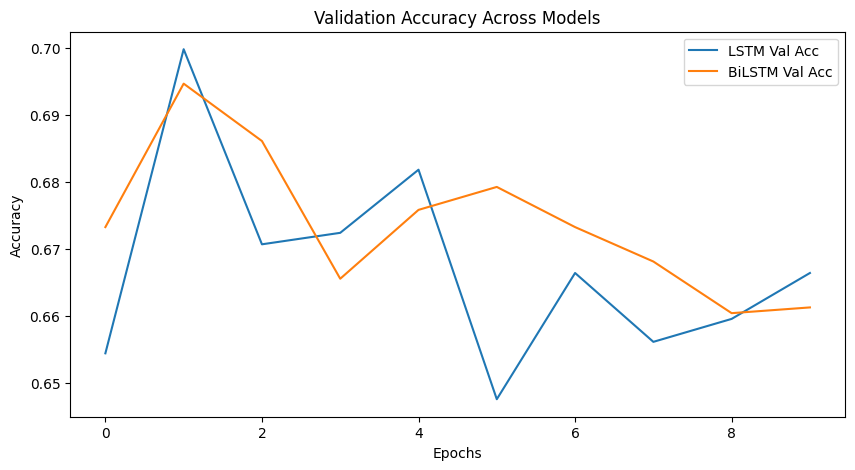

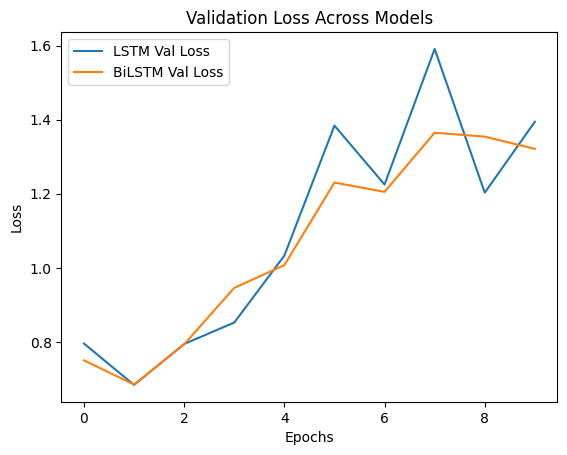

In [ ]:
# Plot accuracies

def compare_models(histories, labels ):
  plt.figure(figsize=(10, 5))
  # Accuracy
  for history, label in zip(histories, labels):
    plt.plot(history.history['val_accuracy'], label=f'{label} Val Acc')
  plt.title("Validation Accuracy Across Models")
  plt.xlabel("Epochs"); plt.ylabel("Accuracy")
  plt.legend(); plt.savefig("acc_plot.png", dpi=300, bbox_inches='tight')
  plt.show()

  # Loss
  for history, label in zip(histories, labels):
    plt.plot(history.history['val_loss'], label=f'{label} Val Loss')
  plt.title("Validation Loss Across Models")
  plt.xlabel("Epochs"); plt.ylabel("Loss")
  plt.legend()
  plt.savefig("loss_plot.png", dpi=300, bbox_inches='tight')
  plt.show()

# plt
compare_models([lstm_training, bi_lstm_training],["LSTM", "BiLSTM"] )



